<center>
<h1>Хакатон Просепт х Практикум ноябрь-декабрь’23.
<br>Команда №15. Хайзенберг team. </h1>    
</center>   

**Состав команды направления DS:**      
**- Грибанов Михаил - Leader** [Telegram](https://t.me/gribanov_m) Выдвижение теорий, проверка моделей.     
**- Сергеев Дмитрий**   [Telegram](https://t.me/SDI84) Анализ данных, проверка моделей.  
**- Шубина Людмила** [Telegram](https://t.me/luybashu) Анализ данных, проверка моделей.

<a name="Содержание"></a>
#### Содержание:
- [1. Цель проекта.](#Цель_проекта)  
- [2. Первичный анализ и обработка данных.](#Первичный_анализ_данных)
 - [2.1. Первичный анализ данных.](#Первичный)
   - [2.1.1. Выводы по первичному анализу данных.](#Выводы_Первичный)
 - [2.2. Обработка данных.](#Обработка_данных)
 - [2.3. Создание тренировочной,валидационной и тестовой выборки.](#Выборки)   
- [3. Выбор и исследование моделей.](#Исследование_моделей)
 - [3.1. Модели обученные на списке товаров производимых заказчиком.](#)
 - [3.2. Модели дообученные на таблице матчинга.](#)
- [4. Тестирование лучшей модели.](#Выбор_лучшей_модели) 
- [5. Выводы.](#Выводы)
 - [5.1. Описание решения](#)

<a name="Цель_проекта"></a>
## 1.Цель проекта.
Разработка решения, которое автоматизирует процесс сопоставления товаров заказчика с размещаемыми товарами дилеров.

[Полное техническое задание заказчика](https://disk.yandex.ru/i/Dt7y-TFbPEp35Q)

[Содержание](#Содержание) 

<a name="Первичный_анализ_данных"></a>
## 2.Первичный анализ и обработка данных.


Импорты необходимых билиотек:

In [1]:
#!pip install modin

In [2]:
#!pip uninstall sentence-transformers

In [3]:
# импорт библиотек
import os
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
#import modin.pandas as pd
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords


from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#Зададим константу случайного распределения
RANDOM_STATE = 42

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
path = 'C:\\Users\\Mikhail\\mushroom\\projects\\Prosept\\'

In [6]:
df_dealer = pd.read_csv(path + "marketing_dealer.csv", sep=";", decimal=",")
df_dealerprice = pd.read_csv(path + "marketing_dealerprice.csv", sep=";", decimal=",")
df_product = pd.read_csv(path + "marketing_product.csv", sep=";", decimal=",")
df_productdealerkey = pd.read_csv(path + "marketing_productdealerkey.csv", sep=";", decimal=",")

<a name="Первичный"></a>
### 2.1. Первичный анализ данных.

Загрузка данных в датафреймы.

Функция представления общей информации о датафрейме.

In [7]:
def express_info(data, name):
    # вывод первых строк данных
    print(f'Первые строки данных {name}:')
    display(data.head())

    # общая информация о данных
    print(f'\nОбщая информация о данных {name}:')
    data.info()
    
    # проверка наличия пропущенных значений
    print(f'\nПропущенные значения {name}:')
    display(data.isnull().sum())

    # проверка наличия дубликатов
    duplicate_count = data.duplicated().sum()
    if duplicate_count > 0:
        print(f'\nКоличество дубликатов в данных {name}: {duplicate_count}')
    else:
        print(f'\nДубликатов в данных {name} не обнаружено.')
    
    # количество уникальных значений
    print(f'\nУникальные значения {name}:')
    display(data.nunique())

#### Информация о датафрейме df_product - список товаров, которые производит и распространяет заказчик.

In [8]:
express_info(df_product, 'Product')

Первые строки данных Product:


,Unnamed: 0,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
0,0,245,008-1,4680008140234.0,Антисептик невымываемыйPROSEPT ULTRAконцентрат...,360.0,858.0,20.0,Антисептик невымываемый для ответственных конс...,Антисептик невымываемый для ответственных конс...,Антисептик невымываемый для ответственных конс...,189522705.0,150033482.0,008-1,NaN
1,1,3,242-12,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,460.16,1075.0,NaN,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,NaN,NaN,NaN,NaN,NaN
2,2,443,0024-06 с,4680008145208.0,"Герметик акриловый цвет сосна, ф/п 600мл",307.0,644.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет сосна, ф/п 600мл",Герметик акриловый для швов для деревянных дом...,189522735.0,150126217.0,0024-06-с,NaN
3,3,147,305-2,4610093420164.0,Кондиционер для белья с ароматом королевского...,157.73,342.0,29.0,"Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...","Кондиционер для белья ""Королевский Ирис"" Prose...",339377922.0,150032962.0,305-2,NaN
4,4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN



Общая информация о данных Product:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         496 non-null    int64 
 1   id                 496 non-null    int64 
 2   article            496 non-null    object
 3   ean_13             464 non-null    object
 4   name               494 non-null    object
 5   cost               491 non-null    object
 6   recommended_price  491 non-null    object
 7   category_id        447 non-null    object
 8   ozon_name          458 non-null    object
 9   name_1c            485 non-null    object
 10  wb_name            455 non-null    object
 11  ozon_article       365 non-null    object
 12  wb_article         340 non-null    object
 13  ym_article         337 non-null    object
 14  wb_article_td      32 non-null     object
dtypes: int64(2), object(13)
memory usage: 58.3+ KB

Пропуще

Unnamed: 0             0
id                     0
article                0
ean_13                32
name                   2
cost                   5
recommended_price      5
category_id           49
ozon_name             38
name_1c               11
wb_name               41
ozon_article         131
wb_article           156
ym_article           159
wb_article_td        464
dtype: int64


Дубликатов в данных Product не обнаружено.

Уникальные значения Product:


Unnamed: 0           496
id                   496
article              496
ean_13               464
name                 487
cost                 338
recommended_price    319
category_id           38
ozon_name            454
name_1c              473
wb_name              451
ozon_article         365
wb_article           339
ym_article           337
wb_article_td         32
dtype: int64

Посмотрим, есть ли дубликаты отдельно по столбцу 'name'

In [9]:
df_product[df_product.duplicated('name', keep=False)].sort_values(by='name')

,Unnamed: 0,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
4,4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN
469,469,363,0024-7б,4680008148872.0,"Герметик акриловой цвет Белый, 7 кг",3149.0,5492.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловой цвет Белый, 7 кг",Герметик акриловый для швов для деревянных дом...,NaN,NaN,NaN,NaN
78,78,362,0024-3б,NaN,"Герметик акриловый цвет Белый, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Белый, 3 кг",NaN,NaN,NaN,NaN,NaN
234,234,223,0024-3 б,4610093420485.0,"Герметик акриловый цвет Белый, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Белый, 3 кг",Герметик акриловый для швов для деревянных дом...,453200111.0,150126218.0,0024-3-б,NaN
94,94,366,0024-3м,NaN,"Герметик акриловый цвет Медовый, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Медовый, 3 кг",NaN,NaN,NaN,NaN,NaN
230,230,225,0024-3 м,4610093420508.0,"Герметик акриловый цвет Медовый, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Медовый, 3 кг",Герметик акриловый для швов для деревянных дом...,453214675.0,150126205.0,0024-3-м,NaN
83,83,374,0024-3о,NaN,"Герметик акриловый цвет Орех, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Орех, 3 кг",NaN,NaN,NaN,NaN,NaN
224,224,224,0024-3 о,4610093420492.0,"Герметик акриловый цвет Орех, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Орех, 3 кг",Герметик акриловый для швов для деревянных дом...,453205718.0,150126215.0,0024-3-о,NaN
84,84,370,0024-3с,NaN,"Герметик акриловый цвет Сосна, 3 кг",1251.0,2145.0,25.0,NaN,"Герметик акриловый цвет Сосна, 3 кг",NaN,NaN,NaN,NaN,NaN
225,225,226,0024-3 с,4610093420515.0,"Герметик акриловый цвет Сосна, 3 кг",1251.0,2145.0,25.0,Герметик акриловый для швов для деревянных дом...,"Герметик акриловый цвет Сосна, 3 кг",Герметик акриловый для швов для деревянных дом...,453215204.0,150126208.0,0024-3-с,NaN


#### Информация о датафрейме df_dealer - список дилеров.

In [10]:
express_info(df_dealer, 'Dealer')

Первые строки данных Dealer:


,id,name
0,1,Moi_vibor_WB
1,2,Akson
2,3,Bafus
3,5,Castorama
4,6,Cubatora



Общая информация о данных Dealer:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18 non-null     int64 
 1   name    18 non-null     object
dtypes: int64(1), object(1)
memory usage: 420.0+ bytes

Пропущенные значения Dealer:


id      0
name    0
dtype: int64


Дубликатов в данных Dealer не обнаружено.

Уникальные значения Dealer:


id      18
name    18
dtype: int64

In [11]:
df_dealer

,id,name
0,1,Moi_vibor_WB
1,2,Akson
2,3,Bafus
3,5,Castorama
4,6,Cubatora
5,7,Komus
6,9,Megastroy
7,10,OnlineTrade
8,11,Petrovich
9,12,sdvor


#### Информация о датафрейме df_dealerprice - результат работы парсера площадок дилеров.

In [12]:
express_info(df_dealerprice, 'Dealerprice')

Первые строки данных Dealerprice:


,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.00,https://akson.ru//p/sredstvo_universalnoe_pros...,Средство универсальное Prosept Universal Spray...,2023-07-11,2
1,3,546408,175.00,https://akson.ru//p/kontsentrat_prosept_multip...,"Концентрат Prosept Multipower для мытья полов,...",2023-07-11,2
2,4,546234,285.00,https://akson.ru//p/sredstvo_dlya_chistki_lyus...,Средство для чистки люстр Prosept Universal An...,2023-07-11,2
3,5,651258,362.00,https://akson.ru//p/udalitel_rzhavchiny_prosep...,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...",2023-07-11,2
4,6,546355,205.00,https://akson.ru//p/sredstvo_moyushchee_dlya_b...,Средство моющее для бани и сауны Prosept Multi...,2023-07-11,2



Общая информация о данных Dealerprice:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            20416 non-null  int64 
 1   product_key   20416 non-null  object
 2   price         20416 non-null  object
 3   product_url   20182 non-null  object
 4   product_name  20416 non-null  object
 5   date          20416 non-null  object
 6   dealer_id     20416 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.1+ MB

Пропущенные значения Dealerprice:


id                0
product_key       0
price             0
product_url     234
product_name      0
date              0
dealer_id         0
dtype: int64


Дубликатов в данных Dealerprice не обнаружено.

Уникальные значения Dealerprice:


id              20416
product_key      1965
price            1286
product_url      1883
product_name     1953
date               14
dealer_id          18
dtype: int64

In [13]:
non_unique_rows = df_dealerprice[~df_dealerprice.duplicated(subset=['product_key','product_name'], keep=False)].sort_values(by='product_key')
non_unique_rows

,id,product_key,price,product_url,product_name,date,dealer_id
20132,20284,382745,1771.00,https://akson.ru//p/ognebiozaschita_prosept_pr...,Огнебиозащита PROSEPT prof 1 группа для наружн...,2023-07-31,2
15443,15492,382753,683.00,https://akson.ru//p/antiseptik_prosept_univers...,Пропитка-антисептик PROSEPT Universal универса...,2023-07-26,2
20152,20304,546235,223.00,https://akson.ru//p/sredstvo_kontsentrirovanno...,Средство концентрированное Prosept Bath Fungi ...,2023-07-31,2
20147,20299,546293,385.00,https://akson.ru//p/sredstvo_dlya_udaleniya_gr...,"Средство для удаления граффити, маркера, краск...",2023-07-31,2
20118,20270,546323,336.00,https://akson.ru//p/udalitel_tsementa_prosept_...,"Удалитель цемента Prosept Cement Cleaner, 500м...",2023-07-31,2
...,...,...,...,...,...,...,...
20284,20439,900996549,294.00,https://www.ozon.ru/product/900996549,Отбеливатель для древесины PROSEPT ECO 50 гото...,2023-07-31,18
6240,6332,928819,318.00,https://vegosm.ru/catalog/interer_i_otdelka/la...,PROSEPT FUNGI CLEAN - удалитель плесени с мине...,2023-07-14,14
19198,19348,https://kub02.ru/catalog/emali/propitka_dlya_k...,406.00,https://kub02.ru/catalog/emali/propitka_dlya_k...,Пропитка для камня гидрофобизирующий состав (1...,2023-07-31,6
19197,19347,https://kub02.ru/catalog/professionalnaya_byto...,396.00,https://kub02.ru/catalog/professionalnaya_byto...,Удалитель ржавчины PROSEPT RUST REMOVER готовы...,2023-07-31,6


[Содержание](#Содержание) 

#### Информация о датафрейме df_productdealerkey  - таблицы матчинга между базой заказчика и товарами, продаваемыми дилерами

In [14]:
express_info(df_productdealerkey, 'Productdealerkey')

Первые строки данных Productdealerkey:


,id,key,dealer_id,product_id
0,1,546227,2,12
1,2,651265,2,106
2,3,546257,2,200
3,4,546408,2,38
4,5,651258,2,403



Общая информация о данных Productdealerkey:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1700 non-null   int64 
 1   key         1700 non-null   object
 2   dealer_id   1700 non-null   int64 
 3   product_id  1700 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.3+ KB

Пропущенные значения Productdealerkey:


id            0
key           0
dealer_id     0
product_id    0
dtype: int64


Дубликатов в данных Productdealerkey не обнаружено.

Уникальные значения Productdealerkey:


id            1700
key           1700
dealer_id       18
product_id     438
dtype: int64

In [15]:
print('Кол-во наименований товаров дилера без наименования из базы заказчика')
len(set(df_dealerprice.product_key)-set(df_productdealerkey.key))

Кол-во наименований товаров дилера без наименования из базы заказчика


363

<a name="Выводы_Первичный"></a>
#### 2.1.1. Выводы по первичному анализу данных.
 
**Выводы по датафрейму 'df_product'** 
 - у производителя 487 наименований товаров
 - Столбцы которые можно использовать как признаки при обучении моделей name, cost, min_recommended_price,recommended_price,     category_id, ozon_name, name_1c, wb_name, содержат пропуски.  
 - Информация представленная в столбцах name не отформатировнна встречаются объединненые слова.  
 - В информации в столбцах article встречатся разный формат записи одного артикля(добавляется пробел).  
 - В столбцах name также присутствуют данные об объеме(весе) продукта, что может быть использовано в качестве признака для модели.
 - Имеются дубликаты имени товара, при этом все дублированные записи имеют разные id-ключ который используется в таблице матчинга товаров заказчика и дилера.  

**Выводы по датафрейму 'df_dealer'** 
 - есть 18 дилеров, продающих товары заказчика
 - аномалий не обнаружено. Только запись spb_Ozon содержит непечатыемые символы, возможно произошла ошибка при выгрузке.

**Выводы по датафрейму 'df_dealerprice'**
- Имеется 1953 уникальных наименования среди товаров заказчика у дилеров, причем одному названию могут соответсвовать разные id
- Столбцы которые можно использовать как признаки при обучении моделей price, priduct_name,dealer_id.
- Имеется большое количество дубликатов по столбцу product_key, product_name.

**Выводы по датафрейму 'df_productdealerkey'**
- не для всех товаров, продаваемых дилерами у нас имеются данные из базы заказчика (для 363 наименований отсутсвуют данные об истинном названии)


***Задачи на обработку данных:***  
- ***для df_product*** удалим из df_name строки в которых отсутствует значение в столбце 'name'. Так же требуется написать функцию по обработке тектса столбцов 'name' (разделение слов, привод к одному размеру, удаление пунктуации, выделение веса(объема) товаров)    
- ***для df_dealer*** обработки не требуется.
- ***для df_dealerprice*** удалить дубликаты по столбцу product_key.

[Содержание](#Содержание) 

<a name="Обработка_данных"></a>
### 2.2. Обработка данных.

In [16]:
# drop rows without names
product = df_product.dropna(subset=['name']).reset_index(drop=True)

[Содержание](#Содержание) 

<a name="Исследование_моделей"></a>
## 3.Исследование моделей.

In [17]:
# Количество ближайших названий
N_COUNT = 20

Для векторизации текстов проверим модели:
- TfidfVectorizer с разными параметрами и после разной очистки текста
- предобученную модель LaBSE

Модель будет возвращать нам список с предложенными вариантами. В качестве **метрик** будем использовать:
- *Accuracy@1* - число правильных ответов из первого предложенного
- *Accuracy@5* - число правильных ответов из пяти предложенных
- *MRR(Mean Reciprocal Rank)* - метрика оценивающая расположение правильного ответа относительно первой позиции

### TfidfVectorizer

Создадим функции для обработки текста, векторизации и рассчета расстояний.

In [18]:
def str_edit_1(res):
    '''Функция принимает на вход строку,
    разделяет пробелами слова и слова и цифры,
    возвращает строку в нижнем регистре с пробелами.
    Ex. ЧистящееСредство500мл -> чистящее средство 500 мл
    '''
    if not pd.isna(res):
        res = ' '.join(re.split(r"([A-Za-z][A-Za-z]*)",res))
        res = ' '.join(re.split(r"([А-ЯЁ][а-я]*)",res))
        res = ' '.join(re.split(r"([0-9][0-9]*)",res))
        res = ' '.join(res.split()).lower()
    else:
        res = ''
        
    return res

In [19]:
def str_edit_2(res):
    '''Функция принимает на вход строку,
    удаляет все знаки пунктуации и слово Prosept,
    возвращает строку в нижнем регистре.
    '''
    if not pd.isna(res):               
        # Lower Casing
        res = res.lower()             
        # Removing all punctuation
        res = re.sub(r"[^а-яa-z\d]+", ' ', res)        
        # remove PROSEPT
        res = re.sub(r"prosept", ' ', res)                       
    else:
        res = ''
        
    return res

In [20]:
# Функции очистки текста
# стоп-слова для английского и русского языков
stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))
# объединим стоп-слова
stop_words = stop_words_en.union(stop_words_ru)

def clean_texts(res):
    # если res - это Series, применяем функцию к каждому элементу
    if isinstance(res, pd.Series):
        return res.apply(clean_texts)
    
    # если res - это строка, выполняем очистку
    if not pd.isna(res):
        # разделение слов
        res = ' '.join(re.split(r"([A-Za-z][A-Za-z]*)", res))
        res = ' '.join(re.split(r"([0-9][0-9]*)", res))
        # нижний регистр
        res = res.lower()
        # Removing all punctuation
        res = re.sub(r"[^а-яa-z\d\s]+", ' ', res)        
        # remove PROSEPT
        res = re.sub(r"prosept", ' ', res)
        # удаление стоп-слов
        res = ' '.join([word for word in res.split() if word not in stop_words])
    else:
        res = ''
    return res

In [21]:
def t_fit(df,df_columns=['name'],analyzer='word',ngram_range=(1,1), max_df=1.0, str_edit=str_edit_1):
    '''Функция форматирует названия и
    векторизует их.
    Возвращает "обученный" векторизатор и векторы названий.
    '''
    vectorizer = TfidfVectorizer(analyzer=analyzer, ngram_range=ngram_range, max_df=max_df)        
    
    df_tmp = df[df_columns[0]].apply(str_edit)
    if len(df_columns)>1:
        for i in range(1,len(df_columns)):
            df_tmp = df_tmp + ' ' + df[df_columns[i]].apply(str_edit)
                       
    matrix = vectorizer.fit_transform(df_tmp)
    model = [vectorizer,matrix]
    return model

In [22]:
def t_predict(txt,model,matrix,count_predict=N_COUNT,metrics = 'cosine_similarity', str_edit=str_edit_1):
    '''Функция форматирует названия дилеров, векторизует их,
    Вычисляет расстояния между векторами названий дилера
    и заказчика.
    Возвращает N_COUNT ближайших расстояний между векторами.
    '''
    dict_metric = {'cosine_similarity':cosine_similarity}
    
    res = dict_metric[metrics](model.transform([str_edit(txt)]),matrix)[0].argsort()[-count_predict:][::-1]
    return res

[Содержание](#Содержание) 

<a name="Выбор_лучшей_модели"></a>
#### Тестирование модели


In [23]:
#Создаем тестовый датафрейм для проверки результатов
df_test = df_productdealerkey.copy()
df_test_dealerprice = df_dealerprice[['product_key','dealer_id','product_name']].copy()
df_test_dealerprice.columns = ['key','dealer_id','product_name']
df_test = df_test.merge(df_test_dealerprice,how='left',on=['key','dealer_id']).drop_duplicates().dropna()
df_test = df_test.merge(product.reset_index()[['index','id','name']],how='left',left_on=['product_id'],right_on=['id'])

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_x          1691 non-null   int64 
 1   key           1691 non-null   object
 2   dealer_id     1691 non-null   int64 
 3   product_id    1691 non-null   int64 
 4   product_name  1691 non-null   object
 5   index         1691 non-null   int64 
 6   id_y          1691 non-null   int64 
 7   name          1691 non-null   object
dtypes: int64(5), object(3)
memory usage: 105.8+ KB


Сначала используем только одно название товара.

In [25]:
my_model = t_fit(product, ['name'])
df_test['predict'] = df_test['product_name'].apply(t_predict,args=(my_model))

In [26]:
# accuracy@5
def t_compare(df):
    return (df['index'] in (df['predict'][0:5])) 

In [27]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')  

Accuracy@5:0.8581


In [28]:
# check if 'index' is first in in the list 'pred_index'
def t_first(df):
    return (df['index'] == df['predict'][0])

In [29]:
first = (df_test[['index','predict']].apply(t_first,axis=1).sum())/len(df_test)
print(f'Accuracy@1:{first:.4}')

Accuracy@1:0.4749


In [30]:
# средняя позиция правильного товара в ранжированном списке
def mean_reciprocal_rank(real_idx, prediction_idx, k=5):
    """
    MRR - вычисление среднего обратного ранга для задачи рекомендации
    real_id - массив с правильными id от заказчика
    prediction_id - массив с предсказаниями, каждая строка - список предсказанных id.
    k - количество предсказанных id
    
    """
    reciprocal_ranks = []

    for i, rec in enumerate(prediction_idx):
        recs = rec[:k]
        relevant = real_idx[i]

        if np.isin(relevant, recs):
            rank = np.where(recs == relevant)[0][0] + 1
            reciprocal_ranks.append(1 / rank)
        else:
            reciprocal_ranks.append(0)

    return np.mean(reciprocal_ranks)

In [31]:
mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}') 

MRR:0.6377


In [32]:
# характеристики модели для сводной таблицы
Model = ['TF-IDF']
Params = ['word, ngram_range=(1,1)']
Names = ['name']
Accuracy5 = [round(acc, 4)]
Accuracy1 = [round(first, 4)]
MRR = [round(mrr, 4)]

Теперь проверим модель при исмользовании всех имен.

In [33]:
my_model = t_fit(product, ['name','ozon_name','name_1c','wb_name'])
df_test['predict'] = df_test['product_name'].apply(t_predict,args=(my_model))

In [34]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.8823
Accuracy@1:0.4997
MRR:0.662


In [35]:
# добавление характеристик модели для сводной таблицы
Model.append('TF-IDF')
Params.append('word, ngram_range=(1,1)')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

Построим словарь не по словам, а по символам и парам символов.

In [36]:
my_model = t_fit(product, ['name','ozon_name','name_1c','wb_name'], 
                 analyzer='char', ngram_range=(1,2), str_edit=str_edit_2)
df_test['predict'] = df_test['product_name'].apply(t_predict,args=(my_model))

In [37]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.9154
Accuracy@1:0.7061
MRR:0.7892


In [38]:
# добавление характеристик модели для сводной таблицы
Model.append('TF-IDF')
Params.append('char, ngram_range=(1,2)')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

Используем функцию очистки текста 

In [39]:
my_model = t_fit(product, ['name','ozon_name','name_1c','wb_name'], 
                 analyzer='char', ngram_range=(1,2), str_edit=clean_texts)
df_test['predict'] = df_test['product_name'].apply(t_predict,args=(my_model))

In [40]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.9166
Accuracy@1:0.7037
MRR:0.7882


In [41]:
# добавление характеристик модели для сводной таблицы
Model.append('TF-IDF')
Params.append('char, ngram_range=(1,2), clean_texts')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

Посмотрим, как изменяется точность в зависимости от предложения разного количества товаров (от 1 до 20)

In [42]:
res = {}
for i in range(1,31):
    def tn_compare(df):
        return (df['index'] in (df['predict'][0:i]))

    acc = df_test[['index','predict']].apply(tn_compare,axis=1).sum()/len(df_test)
    res[i] = acc

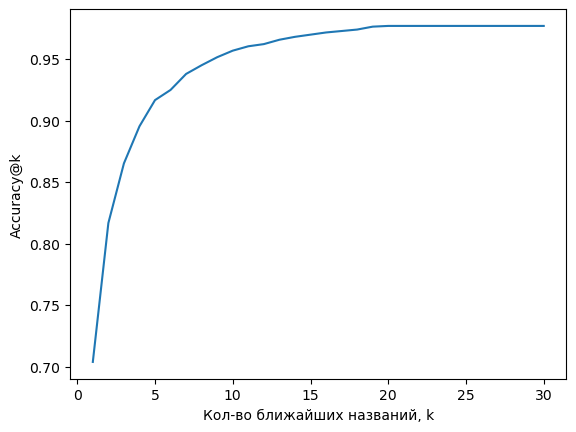

In [43]:
plt.plot(list(res.keys()), list(res.values()))
plt.xlabel('Кол-во ближайших названий, k')
plt.ylabel('Accuracy@k')
plt.show()

[Содержание](#Содержание) 

### LaBSE

Попробуем построить эмбеддинги с помощью предобученной модели LaBSE

In [44]:
# подготовка данных для векторизации
texts_producer = (product['name']+' '+ 
                  product['ozon_name'].astype(str)+' '+
                  product['name_1c'].astype(str)+' '+
                  product['wb_name'].astype(str))
texts_dealer = df_test['product_name']

In [45]:
# загрузка предварительно обученной модели LaBSE
model_LaBSE = SentenceTransformer('LaBSE')

In [46]:
%%time
# преобразование текстов в векторы
producer_vec = model_LaBSE.encode(texts_producer.tolist(), convert_to_tensor=True)
dealer_vec = model_LaBSE.encode(texts_dealer.tolist(), convert_to_tensor=True)

CPU times: total: 9min 25s
Wall time: 2min 22s


In [47]:
# измерение схожести (косинусное сходство)
similarity_matrix = util.pytorch_cos_sim(dealer_vec, producer_vec)

In [48]:
similarity_matrix.shape

torch.Size([1691, 494])

In [49]:
df_test['predict'] = similarity_matrix.topk(N_COUNT).indices.tolist()

In [50]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.9172
Accuracy@1:0.7232
MRR:0.8031


In [51]:
# добавление характеристик модели для сводной таблицы
Model.append('LaBSE')
Params.append('-')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

Используем функцию очистки текста

In [52]:
# Применяем функцию к Series
texts_producer = clean_texts(texts_producer)
texts_dealer = clean_texts(texts_dealer)

In [53]:
# загрузка предварительно обученной модели LaBSE
model_LaBSE = SentenceTransformer('LaBSE')

In [54]:
%%time
# преобразование текстов в векторы
producer_vec = model_LaBSE.encode(texts_producer.tolist(), convert_to_tensor=True)
dealer_vec = model_LaBSE.encode(texts_dealer.tolist(), convert_to_tensor=True)

CPU times: total: 7min 3s
Wall time: 1min 47s


In [55]:
# измерение схожести (косинусное сходство)
similarity_matrix = util.pytorch_cos_sim(dealer_vec, producer_vec)

In [56]:
similarity_matrix.shape

torch.Size([1691, 494])

In [57]:
df_test['predict'] = similarity_matrix.topk(N_COUNT).indices.tolist()

In [58]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.9403
Accuracy@1:0.7457
MRR:0.8272


In [59]:
# добавление характеристик модели для сводной таблицы
Model.append('LaBSE')
Params.append('clean_texts')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

Используем LaBSE для английского и русского языков

In [60]:
# Применяем функцию к Series
texts_producer = clean_texts(texts_producer)
texts_dealer = clean_texts(texts_dealer)

In [61]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

In [62]:
%%time
# преобразование текстов в векторы producer
encoded_producer = tokenizer(texts_producer.tolist(), padding=True, truncation=True, max_length=61, return_tensors='pt')
with torch.no_grad():
    producer_output = model(**encoded_producer)
producer_embeddings = producer_output.pooler_output
producer_vec = torch.nn.functional.normalize(producer_embeddings)

# преобразование текстов в векторы dealer
encoded_dealer = tokenizer(texts_dealer.tolist(), padding=True, truncation=True, max_length=61, return_tensors='pt')
with torch.no_grad():
    dealer_output = model(**encoded_dealer)
dealer_embeddings = dealer_output.pooler_output
dealer_vec = torch.nn.functional.normalize(dealer_embeddings)

CPU times: total: 7min 20s
Wall time: 1min 50s


In [63]:
# измерение схожести (косинусное сходство)
similarity_matrix = util.pytorch_cos_sim(dealer_vec, producer_vec)

In [64]:
similarity_matrix.shape

torch.Size([1691, 494])

In [65]:
df_test['predict'] = similarity_matrix.topk(N_COUNT).indices.tolist()

In [66]:
acc = df_test[['index','predict']].apply(t_compare,axis=1).sum()/len(df_test)
print(f'Accuracy@5:{acc:.4}')

first = df_test[['index','predict']].apply(t_first,axis=1).sum()/len(df_test)
print(f'Accuracy@1:{first:.4}')

mrr=mean_reciprocal_rank(df_test['index'], df_test['predict'])
print(f'MRR:{mrr:0.4}')

Accuracy@5:0.9403
Accuracy@1:0.7546
MRR:0.8324


In [67]:
# добавление характеристик модели для сводной таблицы
Model.append('LaBSE-en-ru')
Params.append('clean_texts, max_length=61')
Names.append('name, ozon_name, name_1c, wb_name')
Accuracy5.append(round(acc, 4))
Accuracy1.append(round(first, 4))
MRR.append(round(mrr, 4))

### Итоговая таблица результатов

In [68]:
# DataFrame with all characteristics
tbl = pd.DataFrame(
    {'Модель': Model,
     'Параметры': Params,
     'Переменные имени': Names,
     'Accuracy@5': Accuracy5,
     'Accuracy@1': Accuracy1,
     'MRR': MRR})

In [69]:
tbl.sort_values(by='Accuracy@5', ascending=False)

,Модель,Параметры,Переменные имени,Accuracy@5,Accuracy@1,MRR
5,LaBSE,clean_texts,"name, ozon_name, name_1c, wb_name",0.9403,0.7457,0.8272
6,LaBSE-en-ru,"clean_texts, max_length=61","name, ozon_name, name_1c, wb_name",0.9403,0.7546,0.8324
4,LaBSE,-,"name, ozon_name, name_1c, wb_name",0.9172,0.7232,0.8031
3,TF-IDF,"char, ngram_range=(1,2), clean_texts","name, ozon_name, name_1c, wb_name",0.9166,0.7037,0.7882
2,TF-IDF,"char, ngram_range=(1,2)","name, ozon_name, name_1c, wb_name",0.9154,0.7061,0.7892
1,TF-IDF,"word, ngram_range=(1,1)","name, ozon_name, name_1c, wb_name",0.8823,0.4997,0.6620
0,TF-IDF,"word, ngram_range=(1,1)",name,0.8581,0.4749,0.6377


<a name="Выводы"></a>
## 5.Выводы.


1. Для выявления самых похожих товаров заказчика для каждого товара дилера простое вычисление расстояний между текстовыми векторами названий товаров дает хорошие результаты.
2. Наиболее точный результат получается при использовании в качестве названия заказчика "сборного названия", где основное наименование дополнено наименованиями для Ozone, Wildberries и 1C.
3. При использовании в качестве векторизатора TF-IDF результат получается лучше при использовании уни и би-грамм символов, возможно, так как в названиях часто встречались написанныеслитнослова. При анализе по словам разбиение пробелами по заглавной букве и между словами и цифрами не решило эту проблему. Удаление пунктуации в первм случае улучшает результат.
4. Лучшая метрика расположения правильного ответа относительно первой позиции (MRR) была достигнута при построении эмбеддингов с помощью предобученной модели LaBSE и использовании предварительной очистки текста. При таком подходе удается рекомендовать правильный товар заказчика первым для 74 сравнений из 100.
5. Стоит отметить, что построение эмбеддингов с помощью предобученной модели LaBSE это времязатратный процесс. В зависимости от мощностей компьютеров заказчика может длиться около 10-30 мин. Стоит оценить, на сколько небольшой выигрыш в точности предложения истинного товара заказчиа первым в списке предложенных оправдывает временные затраты. Так как при использовании для векторизации TF-IDF, также как и предобученной модели LaBSE, истинный товар заказчика нходится в списке 5 предложенны в 92 случаях из 100.
6. Стоит проверить дополнительные методы для улучшения точности ранжирования. Например, обучение классификатора на 20 ближайших именах и выбор 5 (или другого указанного числа) лучших на основании предсказания модели. Было заметно, что более 20 товаров брать вероятно не стоит, точность предсказания не растет. 

**Рекомендации** для заказчика для улучшения модели предсказания.  
- лучше проверять таблицу product, из-за ошибок в заполнении, могут возникнуть неправильные предсказания метчинг(странно, что одинаковому названию соответствует разные id, также исключить ошибки форматирования при запллнении(article,name).
- не указана дата матчинга в датасета матчинга, что приводит к удалению дубликатов в dealerprice случайным образом, хотя скорее всего требовалась привязка по дате.